In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from scipy.stats import pearsonr
from collections import Counter

from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten, GRU, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.random import set_seed

sns.set_palette("Paired")


from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.preprocessing import SplineTransformer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

from keras.layers import BatchNormalization

from tensorflow import compat
compat.v1.logging.set_verbosity(compat.v1.logging.ERROR)

In [2]:
PATH="https://raw.githubusercontent.com/LeiteJu/TCC/main/dados/input/"

SIGLAS = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE',
  'DF', 'ES', 'GO', 'MA',
  'MG', 'MS', 'MT', 'PA', 'PB',
  'PE', 'PI', 'PR', 'RJ',
  'RN', 'RO', 'RR', 'RS',
  'SC', 'SE', 'SP', 'TO']

LABELS=["subestima: -90%", "subestima entre -90% e 60%", "subestima entre -60% e -30%",
        "subestima entre -30% e 10%", "entre -10% e 10%", "superestima entre 10% e 30%", 
        "superestima entre 30% e 60%", "superestima entre 60% e 90%", "superestima mais de 90%"]

N='NORTE'
NE="NORDESTE"
CO='CENTRO OESTE'
SE='SUDESTE'
S = 'SUL'

REGIOES = {
    'AC': N, 'AL': NE, 'AM' : N, 'AP' : N, 'BA' : NE, 'CE' : NE,
    'DF' : CO, 'ES' : SE, 'GO' : CO, 'MA' : NE,
    'MG' : SE, 'MS' : CO, 'MT' : CO, 'PA' : N, 'PB' : NE,
    'PE' : NE, 'PI' : NE, 'PR' : S, 'RJ' : SE,
    'RN' : NE, 'RO' : N, 'RR' : N, 'RS' : S,
    'SC' : S, 'SE' : NE, 'SP' : SE, 'TO' : N}


In [3]:
# calcula metricas de regressao
def score_regression_metrics(y_test, y_test_pred):

    RMSE = mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False)
    MAE = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
    MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)
    R2 = r2_score(y_true=y_test, y_pred=y_test_pred)

    scores = {
        "neg_root_mean_squared_error": RMSE,
        "neg_mean_absolute_error": MAE,
        "neg_mean_absolute_percentage_error": MAPE,
    }

    return scores

def show_scores (scores):

    print ("Scores obtidos:")

    print (f"RMSE: {scores['neg_root_mean_squared_error']}")
    print (f"MAE: {scores['neg_mean_absolute_error']}")
    print (f"MAPE: {scores['neg_mean_absolute_percentage_error']}")

In [4]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [5]:
class Scaler3DShape:
    
    def __init__(self, scaler=StandardScaler):
        self.scaler = scaler() 

    def fit_transform(self, x):
        x_new = self.scaler.fit_transform(x.reshape(-1, x.shape[-1])).reshape(x.shape)
        return x_new

    def transform(self, x):
        x_new = self.scaler.transform(x.reshape(-1, x.shape[-1])).reshape(x.shape)
        return x_new

In [21]:
SEED = 41

def set_seeds (SEED=41):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

set_seeds(SEED)

In [7]:
def load_data():
    
    df = pd.read_csv(f"{PATH}processado.csv")
    
    x  = df.copy()
    x = x.sort_values(["data", "estados"])
    x = x.drop(["consumo", 'data'], axis=1)

    y = df.copy().sort_values(["data", "estados"])[['estados', 'data', 'consumo']]
    
    # processo de one-hot
    x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)

    y = y['consumo']
    
    return x,y

In [8]:
def categorize(x):
    if x < - 0.9:
        return LABELS[0]
    elif x < - 0.6:
        return LABELS[1]
    elif x < - 0.3:
        return LABELS[2]
    elif x < - 0.1:
        return LABELS[3]
    elif x < 0.1:
        return LABELS[4]
    elif x < 0.3:
        return LABELS[5]
    elif x < 0.6:
        return LABELS[6]
    elif x < 0.9:
        return LABELS[7]
    else:
        return LABELS[8]

In [9]:
def get_regiao (x):
    return REGIOES[x]

In [10]:
def get_pred_seq (y_pred, y_test):

    drop = len(y_pred) % 27
    datas = len(y_pred) // 27
    y_pred = y_pred[drop:]
    y_test = y_test[drop:]

    init = pd.to_datetime("072017", format='%m%Y')
    end = pd.to_datetime("122019", format='%m%Y')
    data = pd.date_range(start=init, end=end, freq='MS').date

    pred = pd.DataFrame(list(data) * 27, columns=['data']).sort_values('data')
    
    pred['estados'] = SIGLAS * 30

    pred.set_index()

    pred["y_pred"] = y_pred
    pred["y_test"] = y_test
    pred['regiao'] = pred['estados'].apply(get_regiao)

    return pred

In [11]:
def show_delta (y_test, y_pred):
    
    data=(y_pred - y_test)/y_test

    error = pd.DataFrame(data, columns=['erro'])
    error['categoria']=error['erro'].apply(categorize)
    
    plt.figure(figsize=(28,6))
    
    plt.title("Distribuição do erro")
    plt.xlabel("Categorias")
    plt.ylabel("quantidade")

    g = sns.countplot(data=error, x='categoria', order=LABELS)
    g.set(ylabel="quantidade")
    total = error.shape[0]
    
    for p in g.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()
        y = p.get_height()
        g.annotate(percentage, (x-0.4, y+1),ha='left')
    
    plt.show()
    
    return error

In [12]:
def region_graphs (pred, reg):
    
    plt.figure(figsize=(18,6))
        
    plt.title(f"Visão regional: {reg}")
    
    pred=pred[pred['regiao'] == reg]
    
    plt.ylabel="Consumo"
    sns.scatterplot(data=pred,  x=pred['data'], y='y_test', hue="estados")
    sns.lineplot(data=pred,  x=pred['data'], y='y_pred', hue="estados")
    
        
    plt.show()

In [13]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(GRU(units=64, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 3ms/step
Scores obtidos:
RMSE: 28865.138621473914
MAE: 15977.362038728143
MAPE: 0.17383213254046245
26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 56427.80427470054
MAE: 31426.196809303976
MAPE: 0.36645557696561326


In [14]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(GRU(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 26135.920978060243
MAE: 14112.491975503914
MAPE: 0.17040058646578082
26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 59964.9789590881
MAE: 36952.72603278883
MAPE: 0.37860235770617445


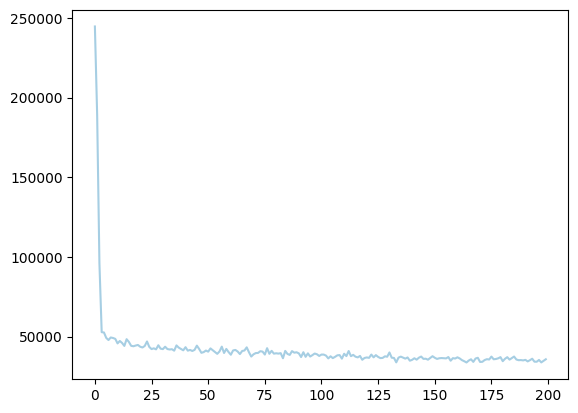

In [15]:
plt.plot(history.history['RMSE'])

In [16]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(GRU(units=256, return_sequences=True, activation="relu")),
model.add(GRU(units=128, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 2s 7ms/step
Scores obtidos:
RMSE: 20308.442822747755
MAE: 11248.176609937687
MAPE: 0.10606971365051755
26/26 [==============================] - 0s 8ms/step
Scores obtidos:
RMSE: 61805.0003273057
MAE: 35617.782621330494
MAPE: 0.3348922809567206


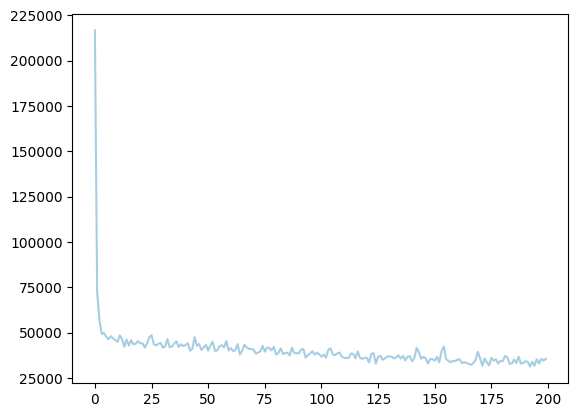

In [17]:
plt.plot(history.history['RMSE'])

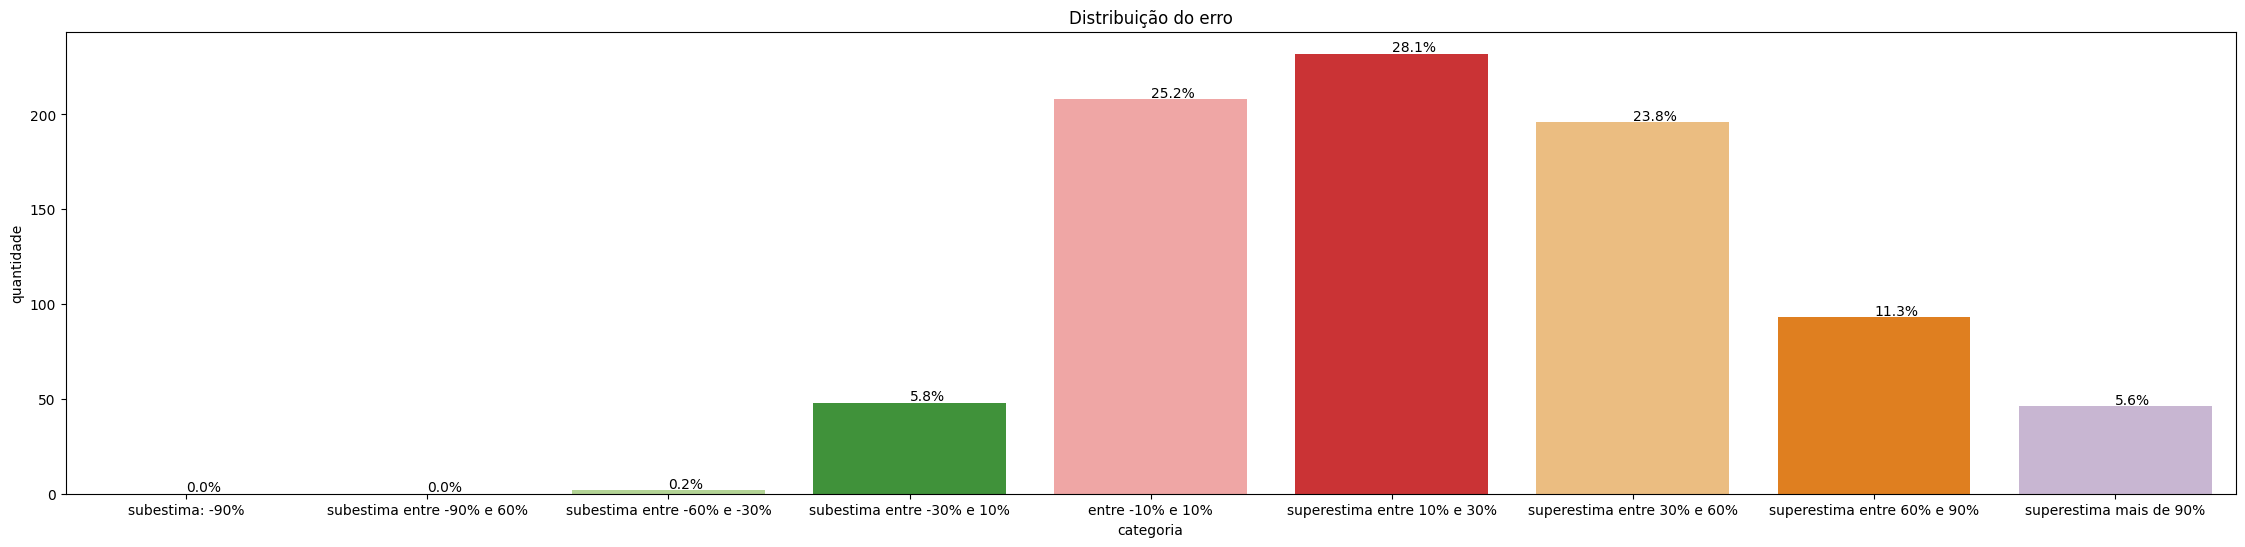

,erro,categoria
0,-0.061687,entre -10% e 10%
1,0.009133,entre -10% e 10%
2,0.250731,superestima entre 10% e 30%
3,0.314353,superestima entre 30% e 60%
4,-0.119027,subestima entre -30% e 10%
...,...,...
820,0.261720,superestima entre 10% e 30%
821,0.322395,superestima entre 30% e 60%
822,0.172790,superestima entre 10% e 30%
823,0.565032,superestima entre 30% e 60%


In [18]:
show_delta(np.array(y_test), y_pred.flatten())

In [19]:
 #novo :)
set_seeds(41)

x,y = load_data()

timestep=5

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(GRU(units=256, return_sequences=True, activation="relu")),
model.add(GRU(units=128, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=250, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 2s 10ms/step
Scores obtidos:
RMSE: 25536.99749747862
MAE: 14575.870515421419
MAPE: 0.11210848483358889
26/26 [==============================] - 0s 7ms/step
Scores obtidos:
RMSE: 64956.88426589056
MAE: 32232.801407768835
MAPE: 0.3387347597978365


In [22]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
# model.add(LSTM(units=128, return_sequences=True, activation="relu")),
model.add(Bidirectional(LSTM(units=256, return_sequences=True, activation="relu"))),
model.add(Bidirectional(LSTM(units=128, return_sequences=True, activation="relu"))),
model.add(Bidirectional(LSTM(64, activation="relu")))
#model.add(LSTM(64, activation="relu"))
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 9s 17ms/step
Scores obtidos:
RMSE: 24048.223204676935
MAE: 14749.073762363669
MAPE: 0.12619856084050485
26/26 [==============================] - 1s 21ms/step
Scores obtidos:
RMSE: 34513.9160804397
MAE: 19845.027296401517
MAPE: 0.18921370143594032


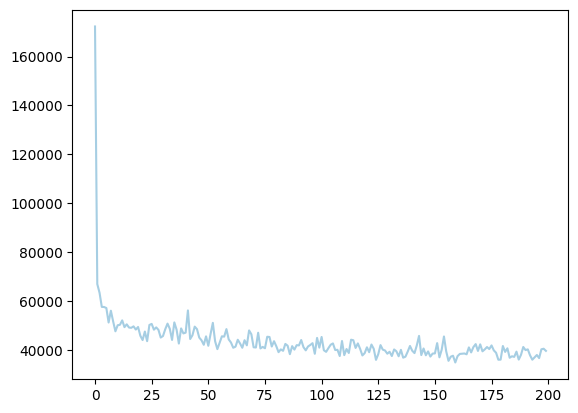

In [23]:
plt.plot(history.history['RMSE'])

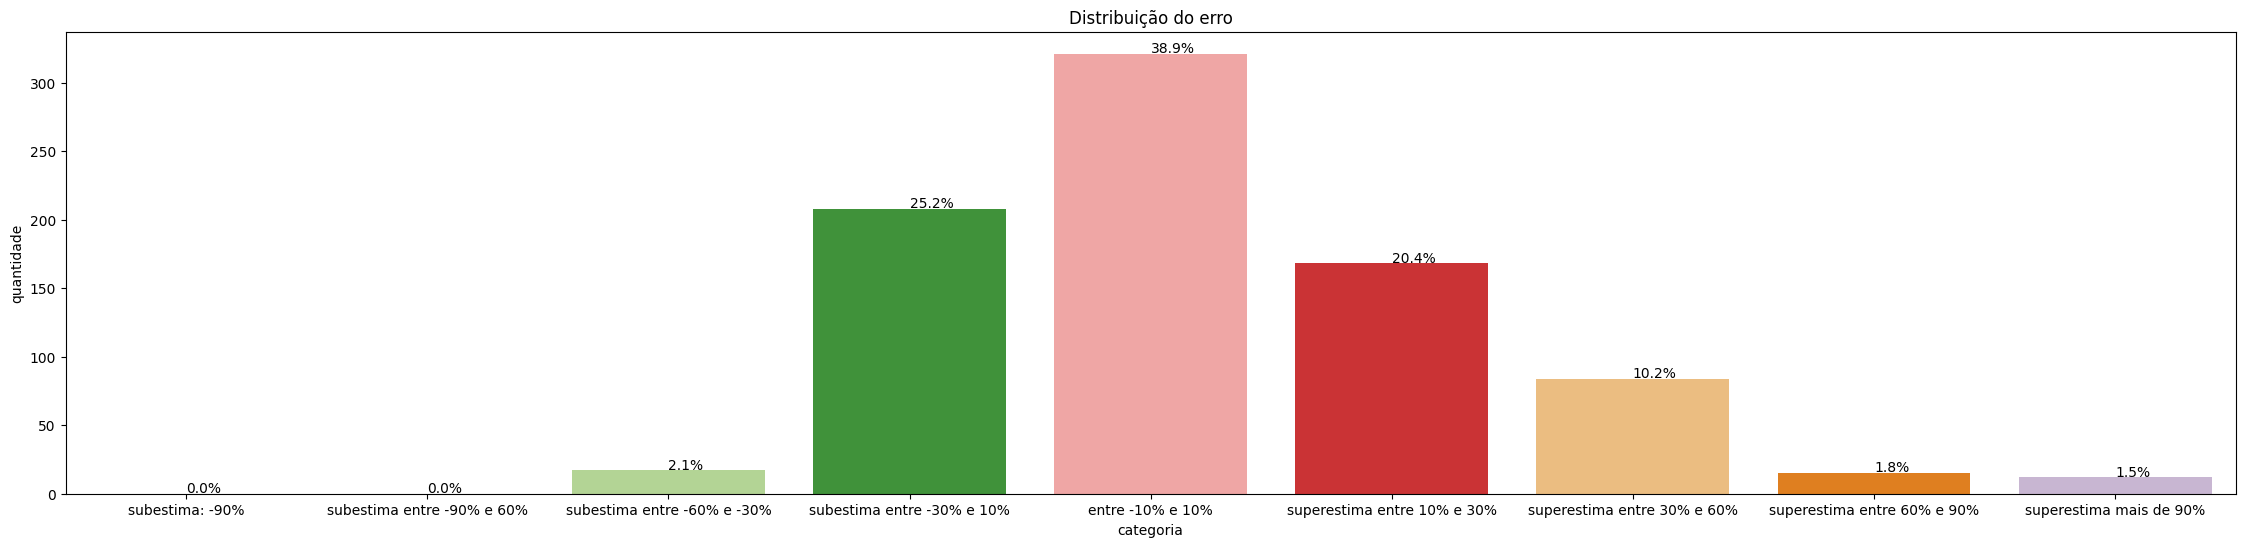

In [24]:
error = show_delta(np.array(y_test), y_pred.flatten())

In [28]:
def get_pred_seq (y_pred, y_test):

    drop = len(y_pred) % 27
    datas = len(y_pred) // 27
    y_pred = y_pred[drop:]
    y_test = y_test[drop:]

    init = pd.to_datetime("072017", format='%m%Y')
    end = pd.to_datetime("122019", format='%m%Y')
    data = pd.date_range(start=init, end=end, freq='MS').date

    pred = pd.DataFrame(list(data) * 27, columns=['data']).sort_values('data')
    
    pred['estados'] = SIGLAS * 30

    pred["y_pred"] = y_pred
    pred["y_test"] = y_test
    pred['regiao'] = pred['estados'].apply(get_regiao)

    return pred

In [41]:
def region_graphs (pred, reg):
    
    plt.figure(figsize=(12,6))
        
    plt.title(f"Visão regional: {reg}")
    
    pred=pred[pred['regiao'] == reg]
    
    plt.ylabel="Consumo"
    sns.scatterplot(data=pred,  x=pred.index, y='y_test', hue="estados")
    sns.lineplot(data=pred,  x=pred.index, y='y_pred', hue="estados")
    
        
    plt.show()

In [43]:
pred = get_pred_seq(y_pred, y_test)

In [44]:
pred = pred.set_index('data')

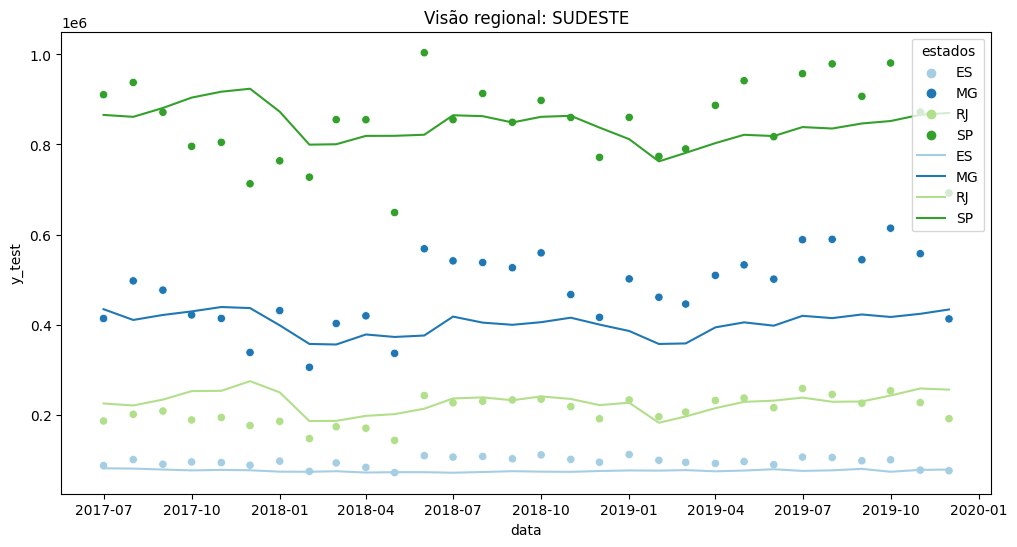

In [45]:
region_graphs(pred, 'SUDESTE')

In [39]:
pred = pred.rename({'y_pred':'previsao', "y_test":'dado_real'}, axis=1)

In [40]:
pred.to_csv('previsoes.csv')